In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import eigsh

import netket.operator as nkop
from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import Ising

import matplotlib.pyplot as plt

<Axes: >

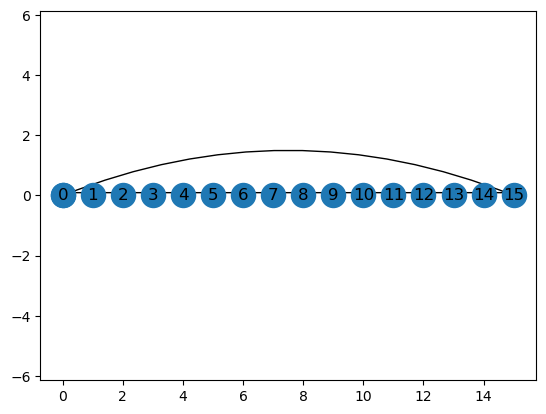

In [2]:
# set system parameters
CHAIN_LENGTH = 16
PERIODIC_BOUNDARIES = True
J_COUPLING = -1.0

#### DRAW GRAPH ####

graph = Hypercube(length=CHAIN_LENGTH, n_dim=1, pbc=PERIODIC_BOUNDARIES)
graph.draw()

In [3]:
hilbert = Spin(s=0.5, N=graph.n_nodes)

def tfim_hamiltonian(hilbert, graph, h, J):
    return Ising(hilbert, graph, h=h, J=J)

def get_ground_state(hamiltonian):
    sp_mat = hamiltonian.to_sparse()
    vals, vecs = eigsh(sp_mat, k=1, which="SA")
    psi = vecs[:, 0]

    # rotate so the largest amplitude is Real and Positive
    first_idx = np.argmax(np.abs(psi))
    psi = psi * np.exp(-1j * np.angle(psi[first_idx]))
    return vals[0], psi


#### CHECK HAMILTONIAN AND GROUND STATE ####

ham_test = tfim_hamiltonian(hilbert, graph, h=1.0, J=J_COUPLING)
E0, psi = get_ground_state(ham_test)

# check physical regime via two-point correlator
u, v = list(graph.edges())[0]
op_zz = nkop.spin.sigmaz(hilbert, u) * nkop.spin.sigmaz(hilbert, v)
zz_corr = (psi.conj().T @ (op_zz.to_sparse() @ psi)).real

phys_regime = "Ferromagnetic (FM)" if zz_corr > 0 else "Antiferromagnetic (AFM)"

# check matrix elements for stoquasticity
sp_mat = ham_test.to_sparse()
off_diag = sp_mat - scipy.sparse.diags(sp_mat.diagonal())
max_off_diag = np.max(off_diag.data.real) if off_diag.nnz > 0 else 0.0
is_stoquastic_ham = max_off_diag <= 1e-12

# check wavefunction amplitudes
max_imag = np.max(np.abs(psi.imag))
min_real = np.min(psi.real)
is_positive_wf = (max_imag < 1e-10) and (min_real > -1e-10)


title = "HAMILTONIAN ANALYSIS"
print(f"==== {title} {'='*(60 - 6 - len(title))}")
print(f"Parameters:               h=1.0, J={J_COUPLING}")
print(f"Ground State Energy:      {E0:.8f}")
print(f"Hamiltonian Stoquastic?   {str(is_stoquastic_ham).upper():<5} (Max Off-Diag H: {max_off_diag:.1e})")
print("="*60)


title = "STATE VECTOR INSPECTION"
print(f"\n==== {title} {'='*(60 - 6 - len(title))}")

sorted_indices = np.argsort(np.abs(psi))[::-1]
print(f"First 5 Dominant Amplitudes:")
print(f"{'Index':<6} | {'Real Part':<11} | {'Imag Part':<11} | {'Sign'}")
print("-"*60)
for i in sorted_indices[:5]:
    val = psi[i]
    if val.real > 1e-6: sign = "+"
    elif val.real < -1e-6: sign = "-"
    else: sign = "0"
    print(f"{i:<6} | {val.real:+.6f}   | {val.imag:+.6f}   | {sign}")

print("-"*60)
print(f"Two-Point Correlator Czz: {zz_corr:+.4f} -> {phys_regime}")
print(f"Wavefunction Real?        {str(max_imag < 1e-10).upper():<5} (Max Imag Psi:   {max_imag:.1e})")
print(f"Wavefunction Positive?    {str(is_positive_wf).upper():<5} (Min Real Psi:   {min_real:.1e})")
print("="*60)


title = "RBM TRAINING VIABILITY"
print(f"\n==== {title} {'='*(60 - 6 - len(title))}")

if is_positive_wf:
    print("SUCCESS: The state is Real and Positive.")
    print("This is valid for a standard amplitude-only RBM.")
elif not is_positive_wf and zz_corr < 0:
    print("FAILURE: System is Antiferromagnetic and Frustrated.")
    print("The ground state has a sign structure. You cannot use a standard RBM.")
else:
    print("WARNING: State is not strictly positive. Check h and J parameters.")
print("="*60)

==== HAMILTONIAN ANALYSIS ==================================
Parameters:               h=1.0, J=-1.0
Ground State Energy:      -20.40459447
Hamiltonian Stoquastic?   TRUE  (Max Off-Diag H: -1.0e+00)

==== STATE VECTOR INSPECTION ===============================
First 5 Dominant Amplitudes:
Index  | Real Part   | Imag Part   | Sign
------------------------------------------------------------
65535  | +0.294437   | +0.000000   | +
0      | +0.294437   | +0.000000   | +
32767  | +0.081055   | +0.000000   | +
65531  | +0.081055   | +0.000000   | +
65503  | +0.081055   | +0.000000   | +
------------------------------------------------------------
Two-Point Correlator Czz: +0.6376 -> Ferromagnetic (FM)
Wavefunction Real?        TRUE  (Max Imag Psi:   0.0e+00)
Wavefunction Positive?    TRUE  (Min Real Psi:   3.7e-05)

==== RBM TRAINING VIABILITY ================================
SUCCESS: The state is Real and Positive.
This is valid for a standard amplitude-only RBM.


CALCULATING RENYI ENTROPY S2
System: TFIM (Ring) with N=16, J=-1.0
Processing Magnetic Field h = 0.5...
Processing Magnetic Field h = 0.8...
Processing Magnetic Field h = 0.95...
Processing Magnetic Field h = 1.0...
Processing Magnetic Field h = 1.05...
Processing Magnetic Field h = 1.2...
Processing Magnetic Field h = 1.5...


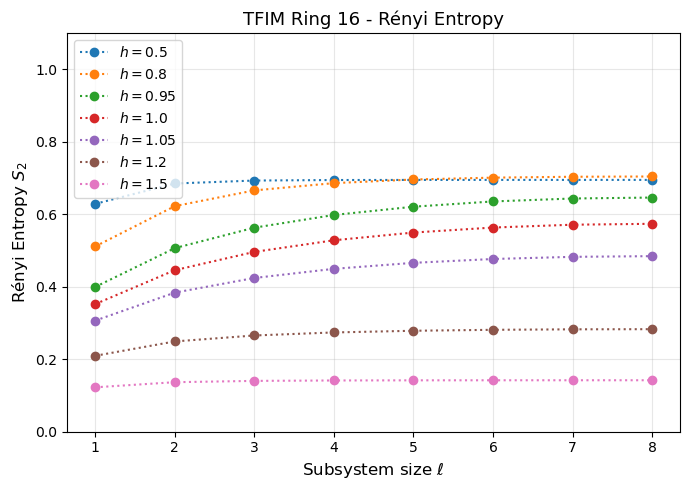

In [4]:
# h values with optional descriptions to be used in legend labels
H_INFO = {0.5: None, 0.8: None, 0.95: None, 1.0: None, 1.05: None, 1.2: None, 1.5: None}
#H_INFO = {0.8: None, 1.0: None, 1.2: None}

MAX_SUBSYSTEM = graph.n_nodes // 2
model_class = "Ring" if PERIODIC_BOUNDARIES else "Open Chain"


# We take the vanilla approach and calculate S2 via Schmidt decomposition (SVD)
def compute_renyi_entropy_s2(psi, n_total, l_sub):
    dim_sub = 2**l_sub
    dim_env = 2**(n_total - l_sub)

    # reshape the wavefunction into a matrix (Subsystem x Environment)
    psi_matrix = psi.reshape((dim_sub, dim_env))

    # compute singular values only
    s_vals = np.linalg.svd(psi_matrix, compute_uv=False)

    # the eigenvalues of the reduced density matrix rho_A are s_vals**2
    purity = np.sum(s_vals**4)
    renyi_entropy_s2 = -np.log(np.maximum(purity, 1e-15))
    return renyi_entropy_s2


print(f"{'='*60}")
print("CALCULATING RENYI ENTROPY S2")
print(f"System: TFIM ({model_class}) with N={graph.n_nodes}, J={J_COUPLING}")
print(f"{'='*60}")

results = {}
l_axis = list(range(1, MAX_SUBSYSTEM + 1))

# Changed iteration variable 'mag' to 'h_val' for clarity
for h_val, desc in H_INFO.items():
    print(f"Processing Magnetic Field h = {h_val}...")

    # build Hamiltonian and get ground state
    ham = tfim_hamiltonian(hilbert, graph, h=float(h_val), J=J_COUPLING)
    _, psi = get_ground_state(ham)

    s2_curve = []
    for l in l_axis:
        val = compute_renyi_entropy_s2(psi, graph.n_nodes, l)
        s2_curve.append(val)

    results[h_val] = s2_curve


# PLOTTING

plt.figure(figsize=(7, 5), dpi=100)

for h_val, desc in H_INFO.items():
    if desc is not None:
        label = rf"$h={h_val}$ - {desc}"
    else:
        label = rf"$h={h_val}$"

    plt.plot(l_axis, results[h_val], marker="o", linestyle=":", label=label)

plt.xlabel(r"Subsystem size $\ell$", fontsize=12)
plt.ylabel(r"Rényi Entropy $S_2$", fontsize=12)
plt.title(f"TFIM {model_class} {graph.n_nodes} - Rényi Entropy", fontsize=13)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(l_axis)

ax = plt.gca()
ax.set_ylim(0.0, 1.1)

plt.tight_layout()
plt.show()

In [5]:
h_sorted = sorted(results.keys())
rows = [[h_val, *results[h_val]] for h_val in h_sorted]
data = np.array(rows, dtype=float)

l_labels = [f"l{l}" for l in l_axis]
# Change "delta" to "h" here so the analysis script finds the right key
header = ",".join(["h"] + l_labels)

file_name = f"tfim_{CHAIN_LENGTH}_entropy_ref.csv"

np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Reference data saved to: {file_name}")

Reference data saved to: tfim_16_entropy_ref.csv
